In [1]:
import os
import sys
import random
from glob import glob
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

# enable use of local modules
repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.galaxy_galaxy import SampleGG, SampleSL2S, SampleBELLS
from mejiro.synth import SyntheticImage
from mejiro.engines.stpsf_engine import STPSFEngine
from mejiro.instruments.roman import Roman
from mejiro.exp import Exposure
from mejiro.utils import util

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F129_1_2048_2048_5_101.npy


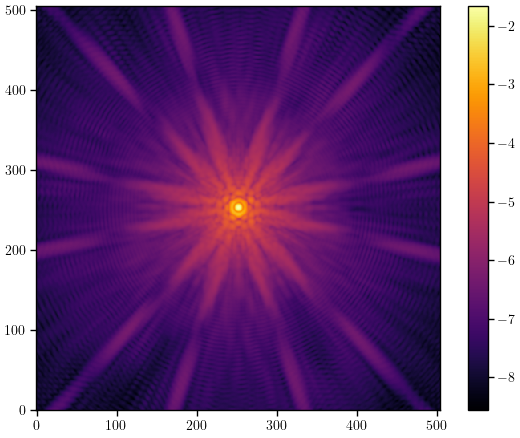

In [10]:
kwargs_psf = STPSFEngine.get_psf_kwargs('F129', 'SCA01', (2048, 2048), oversample=5, num_pix=101, check_cache=True, psf_cache_dir='/data/bwedig/mejiro/cached_psfs', verbose=True)

plt.imshow(np.log10(kwargs_psf['kernel_point_source']), cmap='inferno')
plt.colorbar()
plt.show()

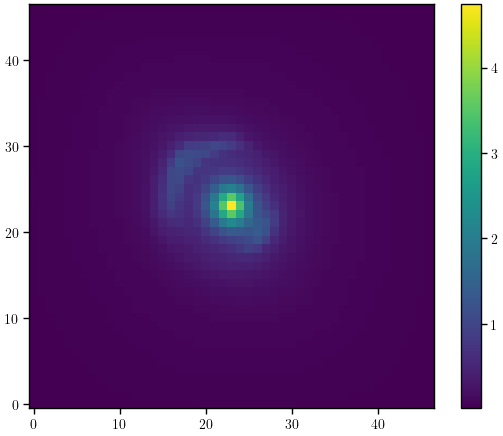

In [28]:
synthetic_image = SyntheticImage(strong_lens=SampleBELLS(),
                                     instrument=Roman(),
                                     band='F129',
                                     fov_arcsec=5,
                                     instrument_params={'detector': 'SCA01'},
                                     kwargs_numerics={},
                                     kwargs_psf=kwargs_psf,
                                     pieces=False,
                                     verbose=False)

plt.imshow(synthetic_image.image)
plt.colorbar()
plt.show()

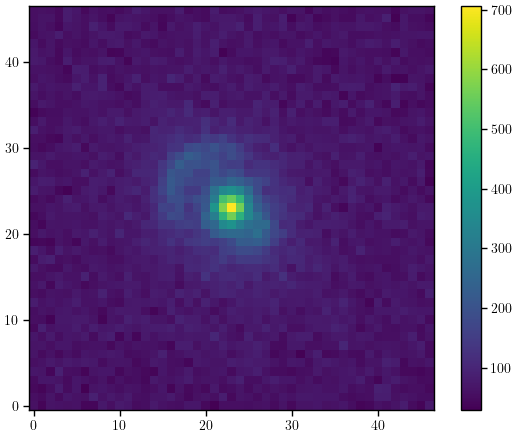

In [29]:
exposure = Exposure(synthetic_image,
                        exposure_time=146,
                        engine='galsim',
                        verbose=False)

plt.imshow(exposure.exposure)
plt.colorbar()
plt.show()